In [69]:
import numpy as np
import pylab
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd

In [51]:
data = pd.read_csv('/Users/weronikasadzik/Downloads/archive (4)/monthly_csv.csv', index_col=0)

# Model Blacka-Scholesa

Równanie Blacka-Scholesa:

$dX(t) = \mu X(t) dt + \sigma X(t) d W_t$

$X(t)$ - cena akcji w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$ (współczynnik dryfu), $\sigma > 0$ (współczynnik dyfuzji)

$W_t$ - proces Wienera

## Estymacja parametrów $\mu, \sigma$ metodą największej wiarygodności

In [75]:
x = data.values
x = [val[0] for val in x]
x = np.array([0, 18, 22, 26, 16, 19, 21, 18, 22, 25, 31, 30, 34, 31, 25, 21, 24, 21, 28, 24, 26, 32,
              33, 36, 39, 32, 33, 42, 44, 43, 48, 50, 56, 57, 59, 51, 49, 49, 57, 69, 72, 75, 76,
f_min = np.inf
a = np.linspace(0.0, 0.1, 1001)
b = np.linspace(0.0, 1.0, 1001)
for ia in tqdm(range(1, 1001)):
    th1 = a[ia]
    for ib in range(1, 1001):
        th2 = b[ib]
        f_log = 0.0
        for j in range(1, 47):
            f = th1 * x[j]
            g = np.sqrt(th2 * x[j])
            mu = x[j] + f
            sigma = g
            temp = -(x[j+1] - mu) ** 2 / (2.0 * sigma**2) - np.log(np.sqrt(2.0 * np.pi * sigma**2))
            f_log -= temp
        if f_log < f_min:
            f_min = f_log
            th1min = th1
            th2min = th2
            
print(f"th1min: {th1min}, th2min: {th2min}, fmin: {f_min}")

  0%|          | 0/1000 [00:00<?, ?it/s]

th1min: 0.0361, th2min: 0.609, fmin: 136.7815779756769


In [72]:
x = np.array([0, 18, 22, 26, 16, 19, 21, 18, 22, 25, 31, 30, 34, 31, 25, 21, 24, 21, 28, 24, 26, 32,
              33, 36, 39, 32, 33, 42, 44, 43, 48, 50, 56, 57, 59, 51, 49, 49, 57, 69, 72, 75, 76,
              78, 73, 73, 75, 86], dtype=np.float32)
fmin = 1000000.0

a1 = 0.0
a2 = 0.1
ha = (a2 - a1) / 1000

b1 = 0.0
b2 = 1.0
hb = (b2 - b1) / 1000

th1 = a1
for ia in tqdm(range(1, 1001)):
    th1 += ha
    th2 = b1
    for ib in range(1, 1001):
        th2 += hb
        flog = 0.0
        for j in range(1, 47):
            def functs(x, th1, th2):
                f = th1 * x
                g = math.sqrt(th2 * x)
                return f, g
            f, g = functs(x[j], th1, th2)
            amu = x[j] + f
            sig = g
            hlp1 = math.log(math.sqrt(2.0 * math.pi * sig * sig))
            hlp2 = -(x[j + 1] - amu) ** 2 / (2.0 * sig * sig) - hlp1
            flog -= hlp2

        if flog > fmin:
            continue

        fmin = flog
        th1min = th1
        th2min = th2

print(f"th1min: {th1min}, th2min: {th2min}, fmin: {fmin}")

  0%|          | 0/1000 [00:00<?, ?it/s]

th1min: 0.03610000000000001, th2min: 0.6090000000000004, fmin: 136.7815779756769


In [67]:
import numpy as np
import math

x = np.array([0, 18, 22, 26, 16, 19, 21, 18, 22, 25, 31, 30, 34, 31, 25, 21, 24, 21, 28, 24, 26, 32,
              33, 36, 39, 32, 33, 42, 44, 43, 48, 50, 56, 57, 59, 51, 49, 49, 57, 69, 72, 75, 76,
              78, 73, 73, 75, 86], dtype=np.float32)

np = 47
fmin = 1000000.0

a1 = 0.0
a2 = 0.1
da = (a2 - a1) / 1000

b1 = 0.0
b2 = 1.0
db = (b2 - b1) / 1000

th1 = a1
for ia in tqdm(range(1, 1001)):
    th1 += da
    th2 = b1
    for ib in range(1, 1001):
        th2 += db
        flog = 0.0
        for j in range(1, 47):
            def functs(x, th1, th2):
                f = th1 * x
                g = math.sqrt(th2 * x)
                return f, g

            f, g = functs(x[j], th1, th2)
            amu = x[j] + f
            sig = g
            hlp1 = math.log(math.sqrt(2.0 * math.pi * sig * sig))
            hlp2 = -(x[j + 1] - amu) ** 2 / (2.0 * sig * sig) - hlp1
            flog -= hlp2

        if flog > fmin:
            continue

        fmin = flog
        th1min = th1
        th2min = th2

print(f"th1min: {th1min}, th2min: {th2min}, fmin: {fmin}")


  0%|          | 0/1000 [00:00<?, ?it/s]

th1min: 0.03610000000000001, th2min: 0.6090000000000004, fmin: 136.7815779756769


In [ ]:
def estimate_parameters():
    

In [6]:
def simulate_Wiener(T, n):
    h = float(T / n)
    W = 0.0
    x = [0.0]
    y = [W]
    normals = np.random.normal(0, 1, n)
    for i in range(1, n+1):
        t = i * h
        W += np.sqrt(h) * normals[i-1]
        x.append(t)
        y.append(W)
    return x, y

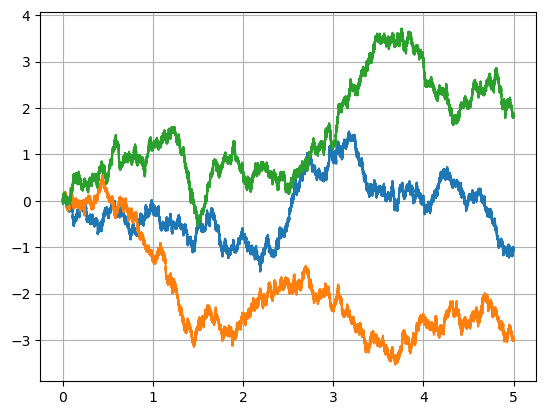

In [20]:
t_disc, W1 = simulate_Wiener(5, 700000)
t_disc, W2 = simulate_Wiener(5, 700000)
t_disc, W3 = simulate_Wiener(5, 700000)

pylab.plot(t_disc, W1)
pylab.plot(t_disc, W2)
pylab.plot(t_disc, W3)

pylab.grid(True)
pylab.show()

In [ ]:
def Euler_Mayorama(k, X_0, T, N, w):
    p = int((N/k)+1)
    w = w[::k]
    x = np.zeros(p)
    y = np.zeros(p)
    x[0] = 0
    y[0] = x_0
    h = T/(p-1)
    for i in range(1, p):
    deltaW = w[i]-w[i-1]
    x[i] = x[i-1]+h
    y[i] = y[i-1]+a(y[i-1])*h+b(y[i-1])*deltaW
    return x, y

In [ ]:
def euler_mayurama_complex(
        f, g, x0, m, h, steps_per_sample, n_samples, include_initial=False):
    """
    Evaluate the Ito-SDE

    .. math::

        dx = f(x,t)dt + g(x,t)dA_t

    using an Euler-Mayurama scheme with fixed stepsize $h$.

    Args:
        f: function for drift term
        g: function for diffusion term
        x0: initial value
        m: number of complex noises
        steps_per_sample: The number of $h$-sized steps between samples
        n_samples: the total number of integration steps
        include_initial: whether or not to include the initial value (and time)
            in the output.

    Returns:
        a tuple ``(times, xs, dAs)``, where ``times`` is an array of times at
        which x is evaluated, ``xs`` is $x$ at different times, and ``dAs`` are
        the noise increments for the time interval $[t, t+h)$
    """
    times = np.zeros(n_samples + 1)
    xs = np.zeros((n_samples + 1, x0.shape[0]), dtype=complex)
    xs[0] = x0
    dAs = np.zeros((n_samples + 1, m), dtype=complex)
    x = np.array(x0, dtype=complex)
    t = 0.
    for nn in range(n_samples):
        dA = (np.random.randn(steps_per_sample, m) * np.sqrt(h) +
              (np.sqrt(h) * 1j) * np.random.randn(steps_per_sample, m))

        def update_step(x_t, dAt):
            return (x_t[0] + f(*x_t) * h + g(*x_t).dot(dAt), x_t[1]+h)

        # for mm in range(steps_per_sample):
        #     x += f(x, t) * h + g(x, t).dot(dA[mm])
        #     t += h
        # print(".",)
        x, t = reduce(update_step, dA, (x, t))
        times[nn+1] = t
        xs[nn+1] = x
        dAs[nn+1] = dA.sum(axis=0)

    if not include_initial:
        return times[1:], xs[1:], dAs[1:]

    return times, xs, dAs

In [ ]:
mu = 2
sigma = 4